<a href="https://colab.research.google.com/github/Glitched404/Heat_Transfer_using_PINNs/blob/main/Temperature_Profile_using_PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU is available and will be used.
Training data file not found. Generating new data...
Training data saved to training_data.npz
Epoch 0, Loss: 10314.46777
Epoch 100, Loss: 7916.25830
Epoch 200, Loss: 7128.45312
Epoch 300, Loss: 6468.91602
Epoch 400, Loss: 5904.03906
Epoch 500, Loss: 5419.68164
Epoch 600, Loss: 5006.11523
Epoch 700, Loss: 4655.32227
Epoch 800, Loss: 4360.20020
Epoch 900, Loss: 4114.24805
Epoch 1000, Loss: 3911.43872
Epoch 1100, Loss: 3746.16162
Epoch 1200, Loss: 3613.20166
Epoch 1300, Loss: 3507.74414
Epoch 1400, Loss: 3425.37817
Epoch 1500, Loss: 3362.11304
Epoch 1600, Loss: 3314.38818
Epoch 1700, Loss: 3279.07812
Epoch 1800, Loss: 3253.49072
Epoch 1900, Loss: 3235.35645
Epoch 2000, Loss: 3222.80420
Epoch 2100, Loss: 3214.33130
Epoch 2200, Loss: 3208.76123
Epoch 2300, Loss: 3205.19873
Epoch 2400, Loss: 3202.98389
Epoch 2500, Loss: 3201.63721
Epoch 2600, Loss: 3186.85205
Epoch 2700, Loss: 1396.12646
Epoch 2800, Loss: 1057.27856
Epoch 2900, Loss: 787.69067
Epoch 3000, L

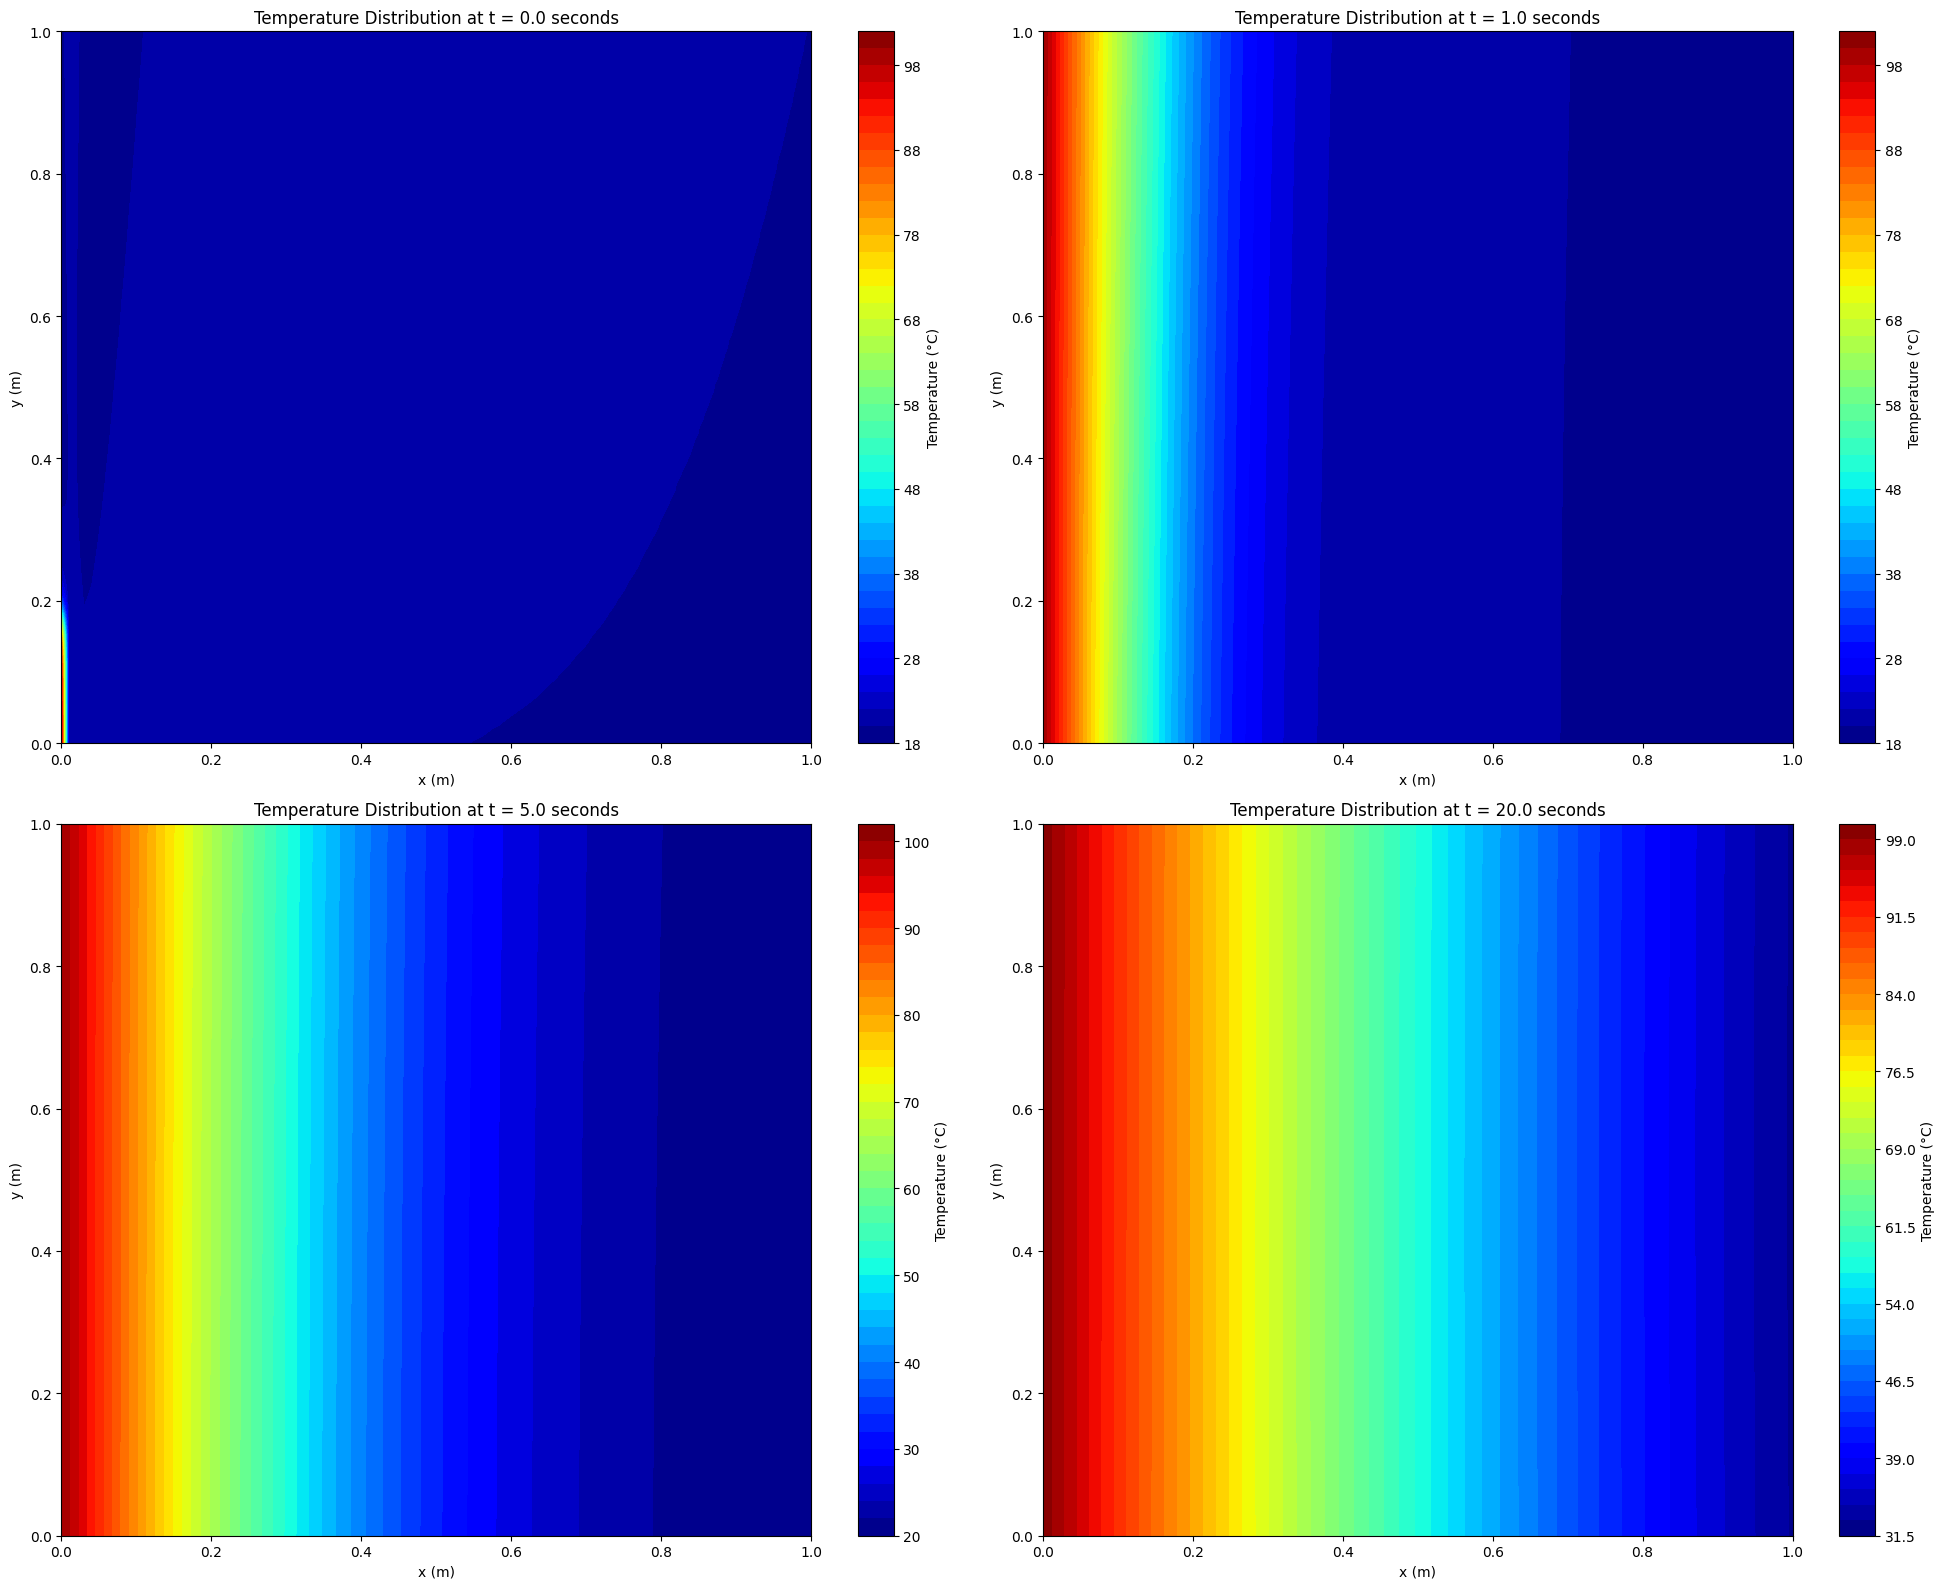

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Configure GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Running on CPU.")

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Problem parameters
rho = 8000.0       # Density (kg/m³) [Example for steel]
C_p = 0.466        # Specific heat capacity (J/(kg·K)) [Example for steel]
k = 45.0           # Thermal conductivity (W/(m·K)) [Example for steel]
alpha = k / (rho * C_p)  # Thermal diffusivity (m²/s)
T_heated = 100.0   # Temperature at heated side (°C)
T_initial = 20.0   # Initial temperature (°C)

# Domain boundaries
x_min, x_max = 0.0, 1.0  # Plate dimensions (meters)
y_min, y_max = 0.0, 1.0
t_min, t_max = 0.0, 20.0 # Simulation time (seconds)


# ... (Your existing code for imports and problem parameters) ...

   # Load training data if available
try:
  with np.load('training_data.npz') as data:
      X_f = tf.constant(data['X_f'], dtype=tf.float32)
      X_b = tf.constant(data['X_b'], dtype=tf.float32)
      T_b = tf.constant(data['T_b'], dtype=tf.float32)
      X_i = tf.constant(data['X_i'], dtype=tf.float32)
      T_i = tf.constant(data['T_i'], dtype=tf.float32)
      print("Training data loaded from training_data.npz")
except FileNotFoundError:
      print("Training data file not found. Generating new data...")
       # ... (Your existing code for generating training data) ...
       # ... (Save the training data using the code from step 1) ...

# Neural network definition
class HeatConductionPINN(tf.keras.Model):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=40, **kwargs):
        super(HeatConductionPINN, self).__init__(**kwargs)
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(3,))  # Define input layer with shape
        self.hidden_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(num_neurons_per_layer,
                                  activation='tanh',
                                  kernel_initializer='glorot_normal')
            for _ in range(num_hidden_layers)
        ])
        self.temp_output = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, **kwargs):
        x = self.hidden_layers(inputs)
        return self.temp_output(x)


# Generate training data
N_f = 10000  # Collocation points
N_b = 2000   # Boundary points
N_i = 5000   # Initial condition points

# Collocation points (x, y, t)
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=tf.float32)
y_f = tf.random.uniform((N_f, 1), y_min, y_max, dtype=tf.float32)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=tf.float32)
X_f = tf.concat([x_f, y_f, t_f], axis=1)

# Boundary points (heated left side at x=0)
x_left = x_min * tf.ones((N_b, 1), dtype=tf.float32)
y_left = tf.random.uniform((N_b, 1), y_min, y_max, dtype=tf.float32)
t_left = tf.random.uniform((N_b, 1), t_min, t_max, dtype=tf.float32)
X_b = tf.concat([x_left, y_left, t_left], axis=1)
T_b = T_heated * tf.ones((N_b, 1), dtype=tf.float32)

# Initial condition points (t=0)
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=tf.float32)
y_i = tf.random.uniform((N_i, 1), y_min, y_max, dtype=tf.float32)
t_i = t_min * tf.ones((N_i, 1), dtype=tf.float32)
X_i = tf.concat([x_i, y_i, t_i], axis=1)
T_i = T_initial * tf.ones((N_i, 1), dtype=tf.float32)

@tf.function
def heat_loss_fn(model, X_f, X_b, T_b, X_i, T_i):
    with tf.GradientTape(persistent=True) as tape:
        # First forward pass for predictions
        tape.watch(X_f)
        T_pred = model(X_f)
        T_pred = tf.squeeze(T_pred)  # Ensure scalar output

        # First derivatives
        grads = tape.gradient(T_pred, X_f)
        dT_dx = grads[:, 0]
        dT_dy = grads[:, 1]
        dT_dt = grads[:, 2]

    # Second derivatives (using persistent tape)
    try:
        d2T_dx2 = tape.gradient(dT_dx, X_f)[:, 0]
        d2T_dy2 = tape.gradient(dT_dy, X_f)[:, 1]
    except TypeError:
        print("Second derivative computation failed, using fallback")
        d2T_dx2 = tf.zeros_like(dT_dx)
        d2T_dy2 = tf.zeros_like(dT_dy)
    finally:
        del tape  # Manually delete persistent tape

    # Physics equation residual
    pde_residual = dT_dt - alpha * (d2T_dx2 + d2T_dy2)
    pde_loss = tf.reduce_mean(tf.square(pde_residual))

    # Boundary conditions
    T_pred_b = model(X_b)
    bc_loss = tf.reduce_mean(tf.square(T_pred_b - T_b))

    # Initial conditions
    T_pred_i = model(X_i)
    ic_loss = tf.reduce_mean(tf.square(T_pred_i - T_i))

    return pde_loss + bc_loss + ic_loss

# Initialize model and optimizer
model = HeatConductionPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = heat_loss_fn(model, X_f, X_b, T_b, X_i, T_i)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Training loop
def train_model(epochs=10000):
    for epoch in range(epochs):
        loss = train_step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.5f}")



# ... (Your existing code for generating training data) ...

# Save training data
np.savez_compressed('training_data.npz',
                  X_f=X_f.numpy(), X_b=X_b.numpy(), T_b=T_b.numpy(),
                  X_i=X_i.numpy(), T_i=T_i.numpy())
print("Training data saved to training_data.npz")





def visualize_heat_distribution(model):
    # Create spatial grid
    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x, y)

    # Time points for visualization
    time_points = [0.0, 1.0, 5.0, t_max]  # t=0, intermediate, intermediate, steady-state

    plt.figure(figsize=(20, 16))
    for i, t in enumerate(time_points):
        # Create input grid with constant time
        T = t * np.ones_like(X).flatten()[:, None]
        XY = np.hstack([X.flatten()[:, None], Y.flatten()[:, None], T])

        # Predict temperatures
        T_pred = model(tf.constant(XY, dtype=tf.float32))
        T_plot = T_pred.numpy().reshape(X.shape)

        # Create subplot
        plt.subplot(2, 2, i+1)
        plt.contourf(X, Y, T_plot, levels=50, cmap='jet')
        plt.colorbar(label='Temperature (°C)')
        plt.title(f'Temperature Distribution at t = {t} seconds')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')

    plt.tight_layout()
    plt.show()

# Train and visualize
train_model(30000)
visualize_heat_distribution(model)


GPU is available and will be used.
Epoch 0, Loss: 10383.32129
Epoch 100, Loss: 7908.12988
Epoch 200, Loss: 7108.35107
Epoch 300, Loss: 6445.82910
Epoch 400, Loss: 5880.64893
Epoch 500, Loss: 5397.20654
Epoch 600, Loss: 4985.19189
Epoch 700, Loss: 4636.29346
Epoch 800, Loss: 4343.22510
Epoch 900, Loss: 4099.37061
Epoch 1000, Loss: 3898.61816
Epoch 1100, Loss: 3735.29785
Epoch 1200, Loss: 3604.15430
Epoch 1300, Loss: 3500.34229
Epoch 1400, Loss: 3419.43555
Epoch 1500, Loss: 3357.43506
Epoch 1600, Loss: 3310.78174
Epoch 1700, Loss: 3276.35791
Epoch 1800, Loss: 3251.48633
Epoch 1900, Loss: 3233.91504
Epoch 2000, Loss: 3221.79297
Epoch 2100, Loss: 3213.63916
Epoch 2200, Loss: 3208.29614
Epoch 2300, Loss: 3204.87476
Epoch 2400, Loss: 3202.81323
Epoch 2500, Loss: 3201.55566
Epoch 2600, Loss: 3200.82129
Epoch 2700, Loss: 3200.38159
Epoch 2800, Loss: 3199.07861
Epoch 2900, Loss: 1489.65662
Epoch 3000, Loss: 1086.85767
Epoch 3100, Loss: 752.68616
Epoch 3200, Loss: 545.71008
Epoch 3300, Loss: 396

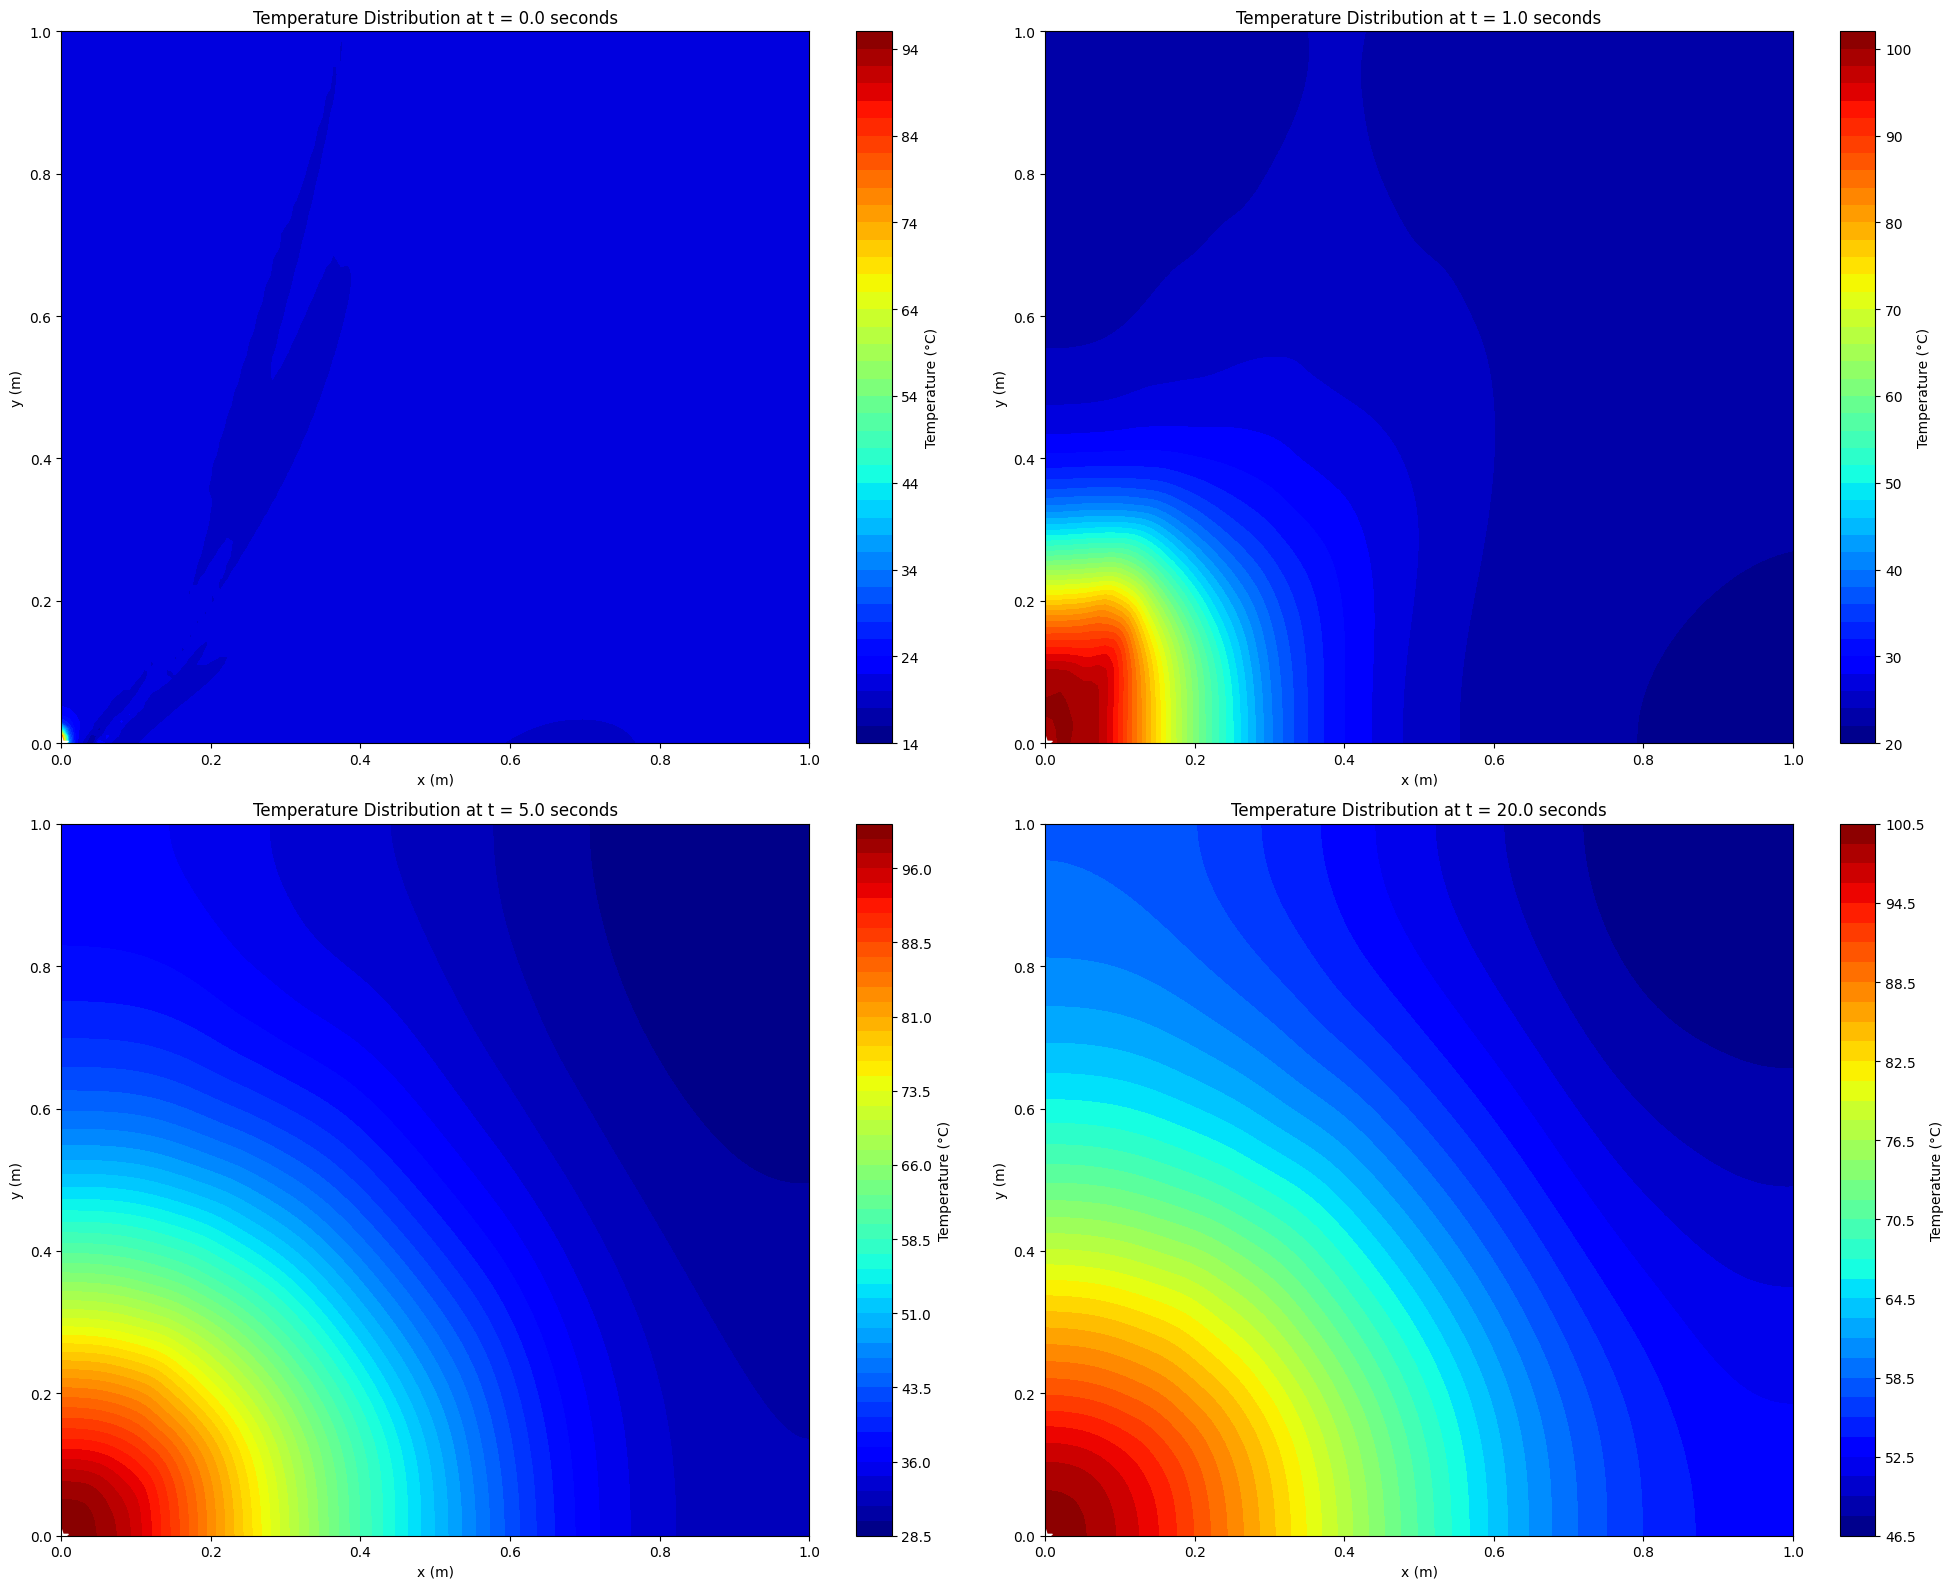

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Configure GPU (if available)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Running on CPU.")

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Problem parameters
rho = 8000.0       # Density (kg/m³)
C_p = 0.466        # Specific heat capacity (J/(kg·K))
k = 45.0           # Thermal conductivity (W/(m·K))
alpha = k / (rho * C_p)  # Thermal diffusivity (m²/s)
T_heated = 100.0   # Temperature at heated corner (°C)
T_initial = 20.0   # Initial temperature (°C)

# Domain boundaries
x_min, x_max = 0.0, 1.0  # Plate dimensions (meters)
y_min, y_max = 0.0, 1.0
t_min, t_max = 0.0, 20.0 # Simulation time (seconds)

# Neural network definition
class HeatConductionPINN(tf.keras.Model):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=40, **kwargs):
        super(HeatConductionPINN, self).__init__(**kwargs)
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(3,))
        self.hidden_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(num_neurons_per_layer,
                                  activation='tanh',
                                  kernel_initializer='glorot_normal')
            for _ in range(num_hidden_layers)
        ])
        self.temp_output = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, **kwargs):
        x = self.hidden_layers(inputs)
        return self.temp_output(x)

# Generate training data
N_f = 10000  # Collocation points
N_b = 2000   # Points per boundary condition
N_i = 5000   # Initial condition points

# Collocation points (x, y, t)
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=tf.float32)
y_f = tf.random.uniform((N_f, 1), y_min, y_max, dtype=tf.float32)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=tf.float32)
X_f = tf.concat([x_f, y_f, t_f], axis=1)

# Dirichlet boundary condition at (0,0) corner
x_b_dir = x_min * tf.ones((N_b, 1), dtype=tf.float32)
y_b_dir = y_min * tf.ones((N_b, 1), dtype=tf.float32)
t_b_dir = tf.random.uniform((N_b, 1), t_min, t_max, dtype=tf.float32)
X_b_dir = tf.concat([x_b_dir, y_b_dir, t_b_dir], axis=1)
T_b_dir = T_heated * tf.ones((N_b, 1), dtype=tf.float32)

# Neumann boundary conditions (insulated boundaries)
# Left edge (x=0, y>0)
x_b_left = x_min * tf.ones((N_b, 1), dtype=tf.float32)
y_b_left = tf.random.uniform((N_b, 1), y_min + 1e-3, y_max, dtype=tf.float32)
t_b_left = tf.random.uniform((N_b, 1), t_min, t_max, dtype=tf.float32)
X_b_left = tf.concat([x_b_left, y_b_left, t_b_left], axis=1)

# Right edge (x=1)
x_b_right = x_max * tf.ones((N_b, 1), dtype=tf.float32)
y_b_right = tf.random.uniform((N_b, 1), y_min, y_max, dtype=tf.float32)
t_b_right = tf.random.uniform((N_b, 1), t_min, t_max, dtype=tf.float32)
X_b_right = tf.concat([x_b_right, y_b_right, t_b_right], axis=1)

# Bottom edge (y=0, x>0)
x_b_bottom = tf.random.uniform((N_b, 1), x_min + 1e-3, x_max, dtype=tf.float32)
y_b_bottom = y_min * tf.ones((N_b, 1), dtype=tf.float32)
t_b_bottom = tf.random.uniform((N_b, 1), t_min, t_max, dtype=tf.float32)
X_b_bottom = tf.concat([x_b_bottom, y_b_bottom, t_b_bottom], axis=1)

# Top edge (y=1)
x_b_top = tf.random.uniform((N_b, 1), x_min, x_max, dtype=tf.float32)
y_b_top = y_max * tf.ones((N_b, 1), dtype=tf.float32)
t_b_top = tf.random.uniform((N_b, 1), t_min, t_max, dtype=tf.float32)
X_b_top = tf.concat([x_b_top, y_b_top, t_b_top], axis=1)

# Initial condition points (t=0)
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=tf.float32)
y_i = tf.random.uniform((N_i, 1), y_min, y_max, dtype=tf.float32)
t_i = t_min * tf.ones((N_i, 1), dtype=tf.float32)
X_i = tf.concat([x_i, y_i, t_i], axis=1)
T_i = T_initial * tf.ones((N_i, 1), dtype=tf.float32)

@tf.function
def heat_loss_fn(model, X_f, X_b_dir, T_b_dir, X_b_left, X_b_right, X_b_bottom, X_b_top, X_i, T_i):
    with tf.GradientTape(persistent=True) as tape:
        # PDE residual calculation
        tape.watch(X_f)
        T_pred = model(X_f)
        T_pred = tf.squeeze(T_pred)

        # First derivatives
        grads = tape.gradient(T_pred, X_f)
        dT_dx = grads[:, 0]
        dT_dy = grads[:, 1]
        dT_dt = grads[:, 2]

        # Second derivatives
        d2T_dx2 = tape.gradient(dT_dx, X_f)[:, 0]
        d2T_dy2 = tape.gradient(dT_dy, X_f)[:, 1]

    # PDE residual
    pde_residual = dT_dt - alpha * (d2T_dx2 + d2T_dy2)
    pde_loss = tf.reduce_mean(tf.square(pde_residual))

    # Dirichlet BC (heated corner)
    T_pred_dir = model(X_b_dir)
    dir_loss = tf.reduce_mean(tf.square(T_pred_dir - T_b_dir))

    # Neumann BCs (insulated boundaries)
    def neumann_loss(X, normal_derivative_index):
        with tf.GradientTape() as t:
            t.watch(X)
            T = model(X)
        dT_dn = t.gradient(T, X)[:, normal_derivative_index]
        return tf.reduce_mean(tf.square(dT_dn))

    left_loss = neumann_loss(X_b_left, 0)    # dT/dx = 0 at x=0
    right_loss = neumann_loss(X_b_right, 0)  # dT/dx = 0 at x=1
    bottom_loss = neumann_loss(X_b_bottom, 1) # dT/dy = 0 at y=0 (x>0)
    top_loss = neumann_loss(X_b_top, 1)       # dT/dy = 0 at y=1

    # Initial condition
    T_pred_i = model(X_i)
    ic_loss = tf.reduce_mean(tf.square(T_pred_i - T_i))

    # Total loss
    return (pde_loss + dir_loss + ic_loss +
            left_loss + right_loss + bottom_loss + top_loss)

# Initialize model and optimizer
model = HeatConductionPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = heat_loss_fn(model, X_f, X_b_dir, T_b_dir,
                           X_b_left, X_b_right, X_b_bottom, X_b_top,
                           X_i, T_i)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train_model(epochs=30000):
    for epoch in range(epochs):
        loss = train_step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.5f}")

def visualize_heat_distribution(model):
    # Create spatial grid
    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x, y)

    # Time points for visualization
    time_points = [0.0, 1.0, 5.0, t_max]

    plt.figure(figsize=(20, 16))
    for i, t in enumerate(time_points):
        XY = np.hstack([X.flatten()[:, None],
                       Y.flatten()[:, None],
                       t * np.ones_like(X).flatten()[:, None]])

        T_pred = model(tf.constant(XY, dtype=tf.float32))
        T_plot = T_pred.numpy().reshape(X.shape)

        plt.subplot(2, 2, i+1)
        plt.contourf(X, Y, T_plot, levels=50, cmap='jet')
        plt.colorbar(label='Temperature (°C)')
        plt.title(f'Temperature Distribution at t = {t} seconds')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.scatter([0], [0], c='white', s=100, marker='*')  # Mark heated corner

    plt.tight_layout()
    plt.show()

# Save training data
np.savez_compressed('training_data_corner.npz',
                  X_f=X_f.numpy(), X_b_dir=X_b_dir.numpy(), T_b_dir=T_b_dir.numpy(),
                  X_b_left=X_b_left.numpy(), X_b_right=X_b_right.numpy(),
                  X_b_bottom=X_b_bottom.numpy(), X_b_top=X_b_top.numpy(),
                  X_i=X_i.numpy(), T_i=T_i.numpy())

# Train and visualize
train_model()
visualize_heat_distribution(model)
